In [1]:
from traffic_data import METRLADatasetLoader # descarga de datos
import numpy as np # manipulacion de datos
import matplotlib.pyplot as plt # graficar
import torch # crear modelos
from torch.utils.data import TensorDataset, DataLoader # manipular dataset
import torch.nn as nn # para usar las capas predefinidas en torch
import torch.optim as optim # para poder utilizar adam como el optimizador
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
from torch_geometric.data import Data, Batch

In [2]:
# cargamos los datos
loader = METRLADatasetLoader() 
adj, weig, x, y = loader.get_dataset(num_timesteps_in=12, 
                                     num_timesteps_out=1)

In [3]:
# omitiremos la variable del tiempo
x = [i[:, 0, :] for i in x]

In [4]:
adj = torch.tensor(adj)

In [5]:
print(len(x), len(y)) # instancias para entrenamiento
print(x[0].shape) # cada instancia tiene 207 nodos en 12 momentos
print(y[0].shape) # el ground truth es el grafo en el siguiente momento

34260 34260
(207, 12)
(207, 1)


In [6]:
# convertimos la lista a un tensor aumentando una dimension mas
# primero convertimos a array porque es mas eficiente 
X = torch.tensor(np.array(x)).permute(0, 2, 1).unsqueeze(-1)
Y = torch.tensor(np.array(y))
print(X.shape)
print(Y.shape)

torch.Size([34260, 12, 207, 1])
torch.Size([34260, 207, 1])


In [7]:
# particionamos en train y test y cargamos los datos en objetos
# DataLoader para mejorar la eficiencia

train_p = 0.8 # porcentaje de training
batch_size = 128

train_size = int(train_p * len(X))
test_size = len(X) - train_size

X_train, X_test = torch.split(X, [train_size, test_size])
Y_train, Y_test = torch.split(Y, [train_size, test_size])

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         shuffle=False, drop_last=True)

In [8]:
X_train.shape

torch.Size([27408, 12, 207, 1])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Cheb_LSTM_Model(nn.Module):
    def __init__(self, node_feature_size, hidden_dim, lstm_layers, output_size, num_nodes):
        super(Cheb_LSTM_Model, self).__init__()
        self.cheb_conv = ChebConv(node_feature_size, hidden_dim, K=1)
        self.lstm = nn.LSTM(hidden_dim * num_nodes, hidden_dim, lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size * num_nodes)
        self.num_nodes = num_nodes

    def forward(self, graph_sequence, edge_index):
        batch_size, seq_len, num_nodes, node_feature_size = graph_sequence.size()

        # Preparar las secuencias de grafos para GATConv
        graph_sequence = graph_sequence.view(batch_size * seq_len, num_nodes, node_feature_size)
        x = graph_sequence.view(-1, node_feature_size)  # (batch_size * seq_len * num_nodes) x node_feature_size

        # Ajustar edge_index para batch processing
        edge_index_batch = edge_index.repeat(1, batch_size * seq_len)
        offset = torch.arange(0, batch_size * seq_len * num_nodes, step=num_nodes, dtype=torch.long).repeat_interleave(edge_index.size(1))
        offset = offset.to(device)
        edge_index_batch = edge_index_batch + offset

        # Procesar todos los grafos en la secuencia de una vez con GATConv
        cheb_output = self.cheb_conv(x, edge_index_batch)
        cheb_output = cheb_output.view(batch_size, seq_len, num_nodes, -1) # -1 = hidden_dim para las features de cada nodo

        # Pasar las salidas de GATConv a LSTM
        cheb_output = cheb_output.view(batch_size, seq_len, -1)  # batch_size x seq_len x (num_nodes * hidden_dim)
        lstm_out, _ = self.lstm(cheb_output)

        # Predecir el siguiente estado del grafo
        lstm_out = lstm_out[:, -1, :]  # batch_size x hidden_dim
        out = self.fc(lstm_out)
        out = out.view(batch_size, num_nodes, -1)  # batch_size x num_nodes x output_size

        return out

In [14]:
node_feature_size = 1 
hidden_dim = 1
lstm_layers = 1
output_size = 1
num_nodes = X_train.size(2)

In [15]:
model = Cheb_LSTM_Model(node_feature_size, hidden_dim, lstm_layers, output_size, num_nodes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
adj = adj.to(device)
print(device)

cuda


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lossi = []

# Entrenamiento del modelo
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Forward 
        outputs = model(X_batch, adj)
        loss = criterion(outputs, Y_batch)
        lossi.append(loss.item())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.3493
Epoch [2/100], Loss: 1.1326
Epoch [3/100], Loss: 1.0623
Epoch [4/100], Loss: 1.3865
Epoch [5/100], Loss: 1.3285
Epoch [6/100], Loss: 1.2272
Epoch [7/100], Loss: 1.1701
Epoch [8/100], Loss: 1.1955
Epoch [9/100], Loss: 0.7923
Epoch [10/100], Loss: 1.2820
Epoch [11/100], Loss: 1.1994


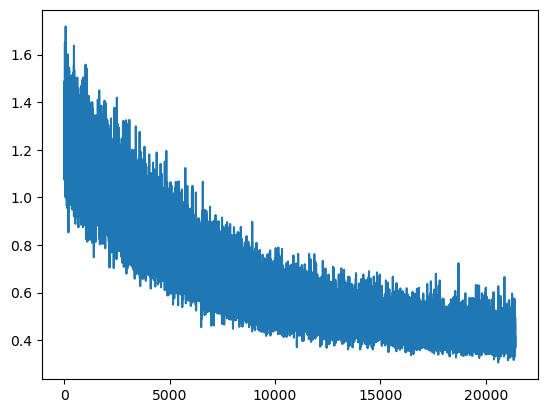

In [ ]:
plt.plot(lossi)